# 5. Learning Curves

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.qda import QDA
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from pandas import DataFrame, Index
from IPython.core.display import HTML

In [2]:
sdss = pd.read_hdf('data/sdss.h5', 'sdss')

In this notebook, we will train some classifiers on the SDSS dataset and compare their performance.

In [2]:
# read in the data
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip", index_col=["ra", "dec"])

# save the names of the 11 feature vectors and the target column
feature_names = ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                 "petroMag_u", "petroMag_g", "petroMag_r", "petroMag_i", "petroMag_z", "petroRad_r"]
target_name = "class"

Since some classifiers such as support vector machines have a time complexity of at least quadratic, we can only train on a small subset of the data for now. Let us select a balanced training set containing 90,000 data points equally distributed among the three classes. Our test set will contain 30,000 data points.

## <a id='s3'></a> 3. Training the Standard Classifiers

Let's train some of the popular classifiers on the SDSS dataset. In particular, we'll look at:

1. Multinomial Naive Bayes
2. Logistic Regression (one-vs-all strategy)
3. SVM (linear kernel, one-vs-one strategy)
4. SVM (RBF kernel, one-vs-one strategy)
5. k-NN (uniform weights, 30 neighbours)
6. k-NN (Euclidean weights, 15 neighbours)
7. Random Forest

In [3]:
# split the data into a training set (90,000 data points) and a test set (30,000 data points)
X_train, X_test, y_train, y_test = balanced_train_test_split(sdss, feature_names, "class", 30000, 10000)

# we'll store results here
confusions, balanced_accuracies, balanced_accuracy_samples = {}, {}, {}

In [24]:
names = ["Multinomial Naive Bayes", "Logistic Regression", "SVM (Linear Kernel)",
              "SVM (RBF Kernel)", "k-NN (Uniform Weights, 30 Neighbours)",
              "k-NN (Euclidean Weights, 15 Neighbours)", "Random Forest"]

# initialise classifiers
classifiers = [MultinomialNB(),
               LogisticRegression(random_state=2),
               SVC(kernel="linear", random_state=3),
               SVC(kernel="rbf", random_state=4),
               KNeighborsClassifier(n_neighbors=30, weights="uniform"),
               KNeighborsClassifier(n_neighbors=15, weights="distance"),
               RandomForestClassifier(n_jobs=-1, random_state=5)]

# train the classifiers and save outputs
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusions[name] = metrics.confusion_matrix(y_test, y_pred)
    balanced_accuracies[name] = balanced_accuracy_expected(confusions[name])
    
    parameters = get_beta_parameters(confusions[name])
    rs = np.random.RandomState(0)
    balanced_accuracy_samples[name] = [beta_avg_inv_cdf(rs.uniform(0, 1), parameters) for _ in range(100)]
    
    # save output for later use
    with open('results/sdss_classification/standard_classifer_' + name + '.pickle', 'wb') as f:
        pickle.dump((clf, confusions[name], balanced_accuracies[name], balanced_accuracy_samples[name]), f, pickle.HIGHEST_PROTOCOL)

We can compare the performance of these 7 classifiers by looking at the posterior distribution of the balanced accuracy. Overall, we can see that with the exception of multinomial naive Bayes, the standard classifiers perform reasonably well, achieving an accuracy rate of around 90%.

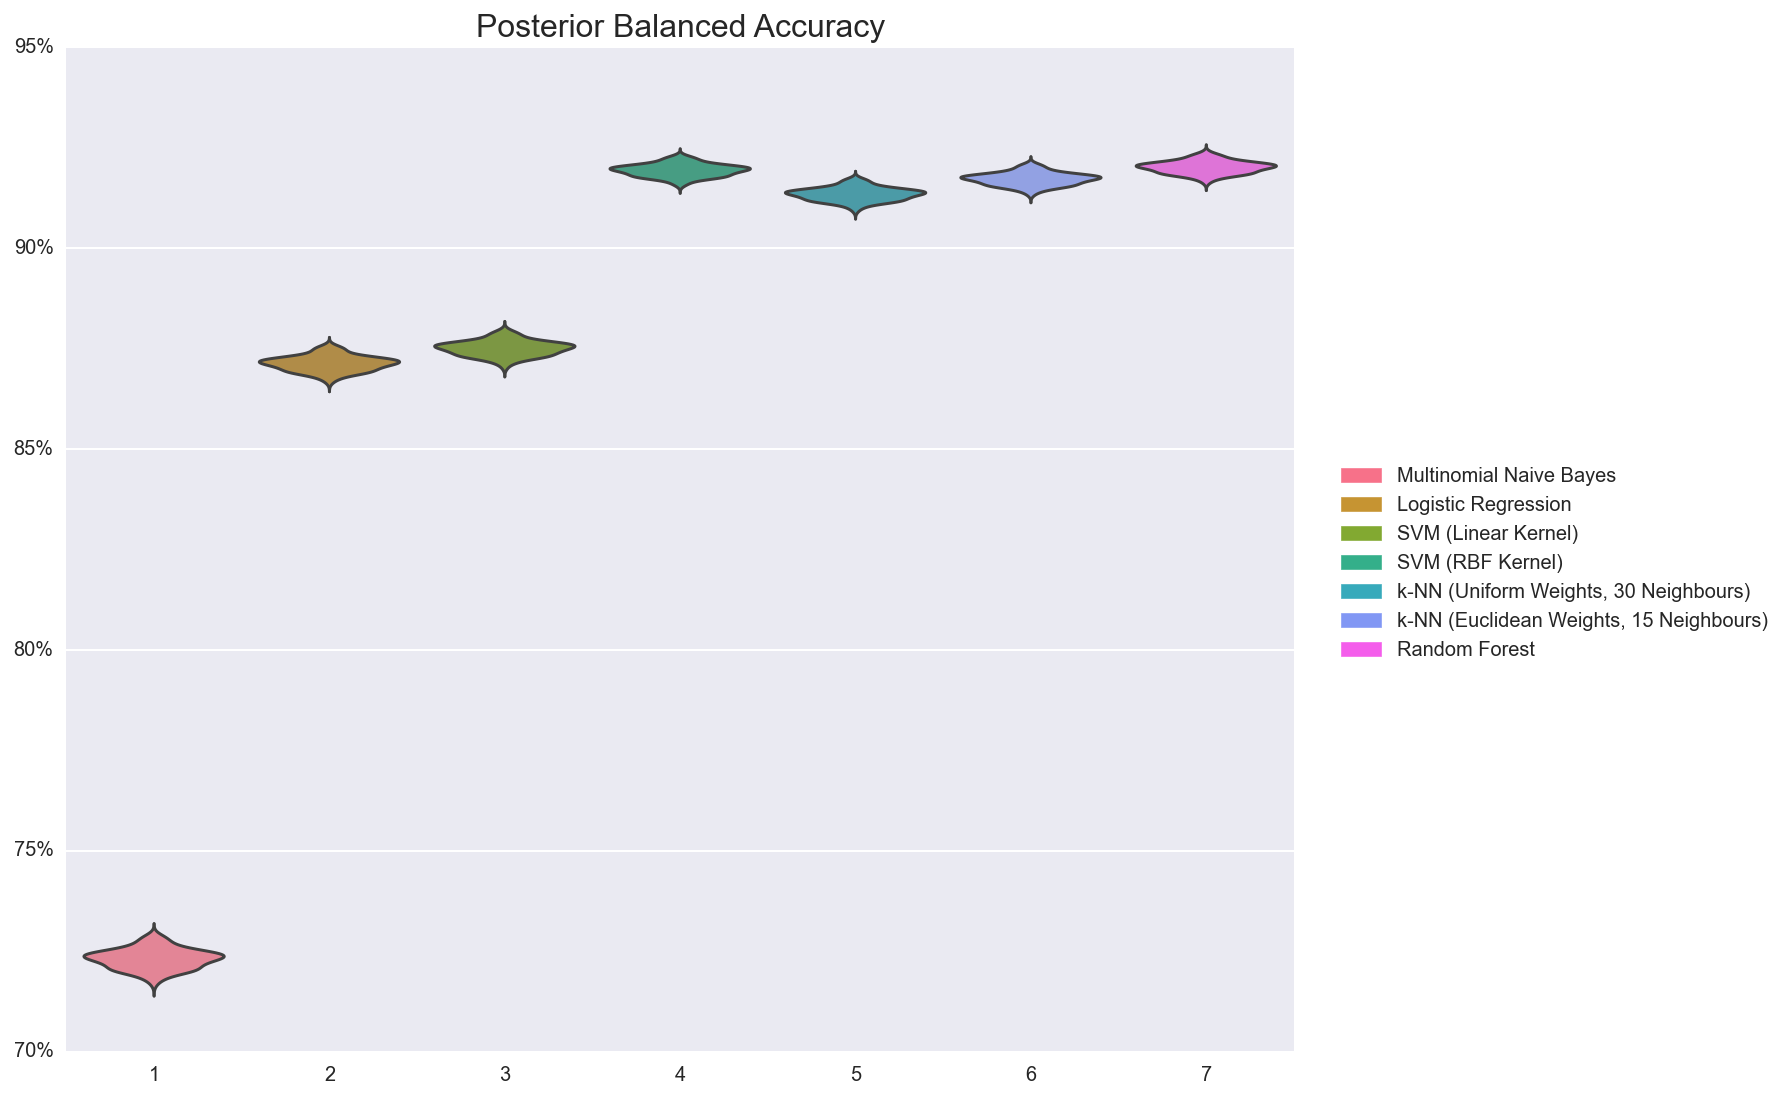

In [3]:
plot_balanced_accuracy_violin(balanced_accuracy_samples, names)

## <a id='s4'></a> 4. Learning Curves

Let's see how the sample size affect the accuracy rate. We'll train the SVM with the RBF kernel.

In [3]:
def learning_curve(sample_sizes, features, targets, clf, clf_name):
    lc_accuracy_test = []

    for i in sample_sizes:
        # split data into test set and training set (balanced classes are not enforced)
        X_train, X_test, y_train, y_test = train_test_split(np.array(features), np.array(targets),
                                                            train_size=i, test_size=30000, random_state=6)

        # train the classifier
        clf.fit(X_train, y_train)

        # apply classifier on test set
        y_pred_test = clf.predict(X_test)
        confusion_test = metrics.confusion_matrix(y_test, y_pred_test)
        lc_accuracy_test.append(balanced_accuracy_expected(confusion_test))

    # save output for later use
    with open('results/sdss_classification/learning_cuve_' + clf_name + '.pickle', 'wb') as f:
        pickle.dump((sample_sizes, lc_accuracy_test), f, pickle.HIGHEST_PROTOCOL)

### RBF Kernel

In [48]:
sample_sizes_svm_rbf = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100001, 10000)))
clf_svm_rbf = SVC(kernel='rbf', random_state=7, cache_size=2000, class_weight='auto')
learning_curve(sample_sizes_svm_rbf, sdss[feature_names], sdss[target_name], clf_svm_rbf, 'svm_rbf')

### Random Forest

In [10]:
sample_sizes_log = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100000, 10000),
                                   np.arange(100000, 1000000, 100000), np.arange(1000000, 2770000, 500000), [2760000]))
clf_forest = RandomForestClassifier(n_estimators=30, n_jobs=-1, class_weight='auto', random_state=5)
learning_curve(sample_sizes_log, sdss[feature_names], sdss[target_name], clf_forest, 'random_forest')

### Nearest Neighbours

In [13]:
clf_k_neighbours = KNeighborsClassifier(n_neighbors=15, weights="distance")
learning_curve(sample_sizes_log, sdss[feature_names], sdss[target_name], clf_k_neighbours, 'k_neighbours')

### Inhomogenous Polynomial Kernels

In [7]:
sample_sizes_log_poly = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100000, 10000),
                                        np.arange(100000, 200001, 100000)))

poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
sdss_poly_targets = sdss[target_name][:1000000]
sdss_poly_features_2 = poly_features.fit_transform(sdss[feature_names][:1000000])

clf_svm_poly_2_l2 = LinearSVC(penalty='l2', dual=False, class_weight='auto', random_state=7)
learning_curve(sample_sizes_log_poly, sdss_poly_features_2, sdss_poly_targets, clf_svm_poly_2_l2, 'svm_poly_2_l2')

clf_svm_poly_2_l1 = LinearSVC(penalty='l1', dual=False, class_weight='auto', random_state=7)
learning_curve(sample_sizes_log_poly, sdss_poly_features_2, sdss_poly_targets, clf_svm_poly_2_l1, 'svm_poly_2_l1')

In [21]:
sample_sizes_log_poly = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100001, 10000)))

poly_features = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
sdss_poly_features_3 = poly_features.fit_transform(sdss[feature_names][:200000])
sdss_poly_targets = sdss[target_name][:200000]

clf_svm_poly_3_l2 = LinearSVC(penalty='l2', dual=False, class_weight='auto', random_state=7)
learning_curve(sample_sizes_log_poly, sdss_poly_features_3, sdss_poly_targets, clf_svm_poly_3_l2, 'svm_poly_3_l2')

clf_svm_poly_3_l1 = LinearSVC(penalty='l1', dual=False, class_weight='auto', random_state=7)
learning_curve(sample_sizes_log_poly, sdss_poly_features_3, sdss_poly_targets, clf_svm_poly_3_l1, 'svm_poly_3_l1')

### Learning Curve Results

In [5]:
with open('results/sdss_classification/learning_cuve_svm_rbf.pickle', 'rb') as f:
    sample_sizes_svm_rbf, lc_accuracy_test_svm_rbf = pickle.load(f)

with open('results/sdss_classification/learning_cuve_random_forest.pickle', 'rb') as f:
    sample_sizes_forest, lc_accuracy_test_forest = pickle.load(f)
    
with open('results/sdss_classification/learning_cuve_k_neighbours.pickle', 'rb') as f:
    sample_sizes_neigh, lc_accuracy_test_neigh = pickle.load(f)

with open('results/sdss_classification/learning_cuve_svm_poly_2_l1.pickle', 'rb') as f:
    sample_sizes_svm_poly_2_l1, lc_accuracy_test_svm_poly_2_l1 = pickle.load(f)

with open('results/sdss_classification/learning_cuve_svm_poly_2_l2.pickle', 'rb') as f:
    sample_sizes_svm_poly_2_l2, lc_accuracy_test_svm_poly_2_l2 = pickle.load(f)
    
with open('results/sdss_classification/learning_cuve_svm_poly_3_l1.pickle', 'rb') as f:
    sample_sizes_svm_poly_3_l1, lc_accuracy_test_svm_poly_3_l1 = pickle.load(f)
    
with open('results/sdss_classification/learning_cuve_svm_poly_3_l2.pickle', 'rb') as f:
    sample_sizes_svm_poly_3_l2, lc_accuracy_test_svm_poly_3_l2 = pickle.load(f)

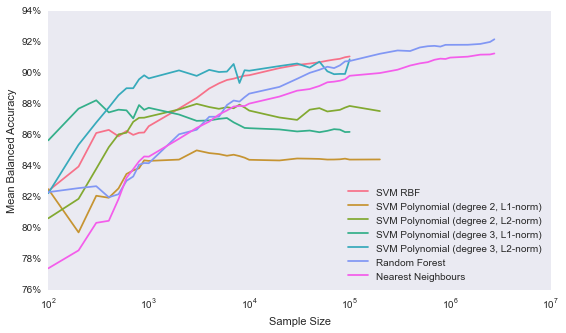

In [6]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(sample_sizes_svm_rbf, lc_accuracy_test_svm_rbf, label = 'SVM RBF')
ax.plot(sample_sizes_svm_poly_2_l1, lc_accuracy_test_svm_poly_2_l1, label = 'SVM Polynomial (degree 2, L1-norm)')
ax.plot(sample_sizes_svm_poly_2_l2, lc_accuracy_test_svm_poly_2_l2, label = 'SVM Polynomial (degree 2, L2-norm)')
ax.plot(sample_sizes_svm_poly_3_l1, lc_accuracy_test_svm_poly_3_l1, label = 'SVM Polynomial (degree 3, L1-norm)')
ax.plot(sample_sizes_svm_poly_3_l2, lc_accuracy_test_svm_poly_3_l2, label = 'SVM Polynomial (degree 3, L2-norm)')
ax.plot(sample_sizes_forest, lc_accuracy_test_forest, label = 'Random Forest')
ax.plot(sample_sizes_neigh, lc_accuracy_test_neigh, label = 'Nearest Neighbours')
#ax.set_title('Learing Curves of Various Classifiers')
format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
ax.legend(loc='lower right')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Mean Balanced Accuracy')
ax.set_xscale('log')
ax.grid(False)
fig.savefig('reports/source/seminar_2_midterm/images/learning_curves.pdf', bbox_inches='tight')

plt.show()

In [22]:
svm_clf = SVC(kernel='rbf', random_state=7, cache_size=2000, class_weight='auto', probability=True)
X_train, X_test, y_train, y_test = train_test_split(np.array(sdss[feature_names]), np.array(sdss[target_name]),
                                                    train_size=100000, test_size=100000, random_state=6)

In [23]:
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=2000, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=True, random_state=7,
  shrinking=True, tol=0.001, verbose=False)

In [24]:
y_pred = svm_clf.predict(X_test)
balanced_accuracy_expected(metrics.confusion_matrix(y_test, y_pred))

0.91537690932953386

In [28]:
thresholds_logistic = np.arange(0, 1, 0.02)
accuracies_logistic = []
percent_unknowns_logistic = []

# compute the probability from the linear predictor (returned by `decision_function`)
probabilities = svm_clf.predict_proba(X_test[:10000])

# take the max probability for each test sammple
max_probs = probabilities.max(axis=1)



In [29]:
for t in thresholds_logistic:
    # select only objects from test set where the likelihood from all classes is higher than threshold
    high_probabilities_index = probabilities.max(axis=1) > t
    percent_unknowns_logistic.append(sum(np.invert(high_probabilities_index)) / 10000)
    X_test_high = X_test[:10000][high_probabilities_index]
    y_test_high = y_test[:10000][high_probabilities_index]
    
    # with above selection, predict the class
    y_pred_test_high = svm_clf.predict(X_test_high)
    confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
    accuracies_logistic.append(balanced_accuracy_expected(confusion_test_high))

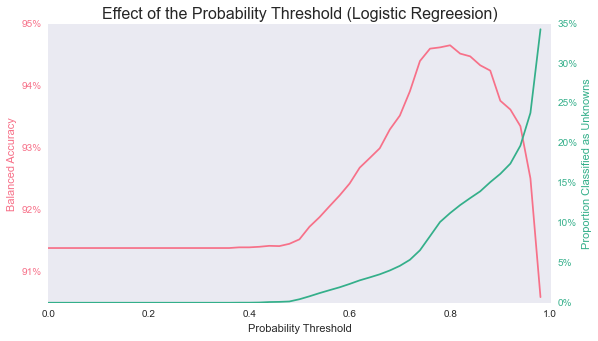

In [30]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

ax1.plot(thresholds_logistic, accuracies_logistic, color=colour1)
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Effect of the Probability Threshold (Logistic Regreesion)')
format_as_percent = lambda x, pos: "{:.0f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)

ax2 = ax1.twinx()
ax2.plot(thresholds_logistic, percent_unknowns_logistic, color=colour2)
ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()

## <a id='s5'></a> 5. Probablisitic Approach with QDA

A simple approach to classify unknown objects is to fit a Gaussian distribution to the features of each class. Then, given a test object, we can compute the likelihood function of each class. If the value of the likelihood is too low for all of the classes, we'd classify the object as an unknown. We'll investigate how varying the likelihood threshold will affect the accuracy rate and the number of identified unknowns.

In [253]:
train_size = 2000000
test_size = 30000
X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss[target_name],
                                                    train_size=train_size, test_size=test_size, random_state=6)
clf_QDA = QDA()
clf_QDA.fit(X_train, y_train)

thresholds = np.arange(0, 30, 0.5)
accuracies_QDA = []
percent_unknowns = []

for t in thresholds:
    # `decision_function` computes the log (likelihood * prior)
    # exponentiate this to get the likelihood function
    likelihood = np.exp(clf_QDA.decision_function(X_test))
    
    # select only objects from test set where the likelihood from all classes is higher than threshold
    high_likelihood_index = likelihood.max(axis=1) > t
    percent_unknowns.append(sum(np.invert(high_likelihood_index)) / test_size)
    X_test_high = X_test[high_likelihood_index]
    y_test_high = y_test[high_likelihood_index]
    
    # with above selection, predict the class
    y_pred_test_high = clf_QDA.predict(X_test_high)
    confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
    accuracies_QDA.append(balanced_accuracy_expected(confusion_test_high))

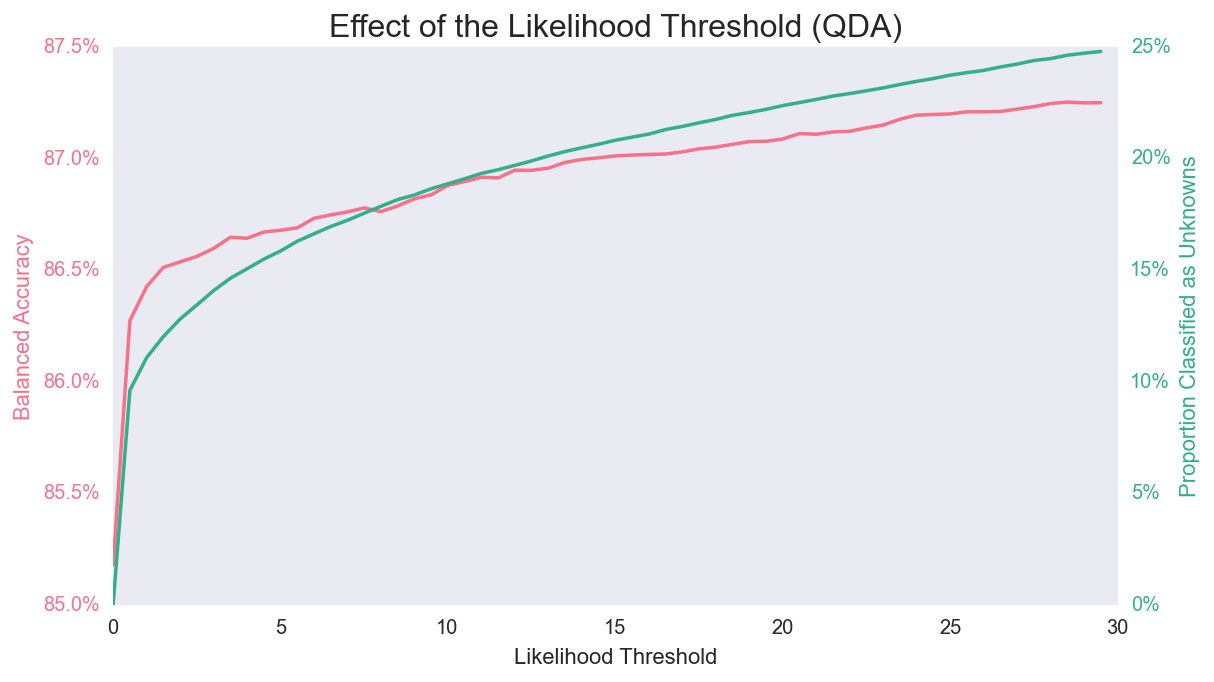

In [256]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

ax1.plot(thresholds, accuracies_QDA, color=colour1)
ax1.set_xlabel('Likelihood Threshold')
ax1.set_title('Effect of the Likelihood Threshold (QDA)')
format_as_percent1 = lambda x, pos: "{:.1f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent1))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)

ax2 = ax1.twinx()
ax2.plot(thresholds, percent_unknowns, color=colour2)
format_as_percent2 = lambda x, pos: "{:.0f}%".format(x * 100)
ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent2))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()

## <a id='s6'></a> 6. Probabilistic Approach with One-vs-Rest Logistic Regression

The one-vs-rest logistic regression in `scikit-learn` can compute the linear predictor $\eta_i$ by calling `decision_function()`. From this we can calculate the probability $p_i$ of being in class $i$ by using the sigmoid function:
    \begin{aligned}
    p_i = \dfrac{1}{1 + e^{-\eta_i}}
    \end{aligned}

Again, let's see how changing the cut-off probability affect the accuracy rate and the number of unknowns identified in the test set.

In [4]:
train_size = 2000000
test_size = 30000
X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss[target_name],
                                                    train_size=train_size, test_size=test_size, random_state=6)
clf_logistic = LogisticRegression(random_state=2)
clf_logistic.fit(X_train, y_train)

thresholds_logistic = np.arange(0, 1, 0.02)
accuracies_logistic = []
percent_unknowns_logistic = []

# compute the probability from the linear predictor (returned by `decision_function`)
probabilities = clf_logistic.decision_function(X_test)
probabilities *= -1
np.exp(probabilities, probabilities)
probabilities += 1
np.reciprocal(probabilities, probabilities)

# take the max probability for each test sammple
max_probs = probabilities.max(axis=1)

for t in thresholds_logistic:
    # select only objects from test set where the likelihood from all classes is higher than threshold
    high_probabilities_index = probabilities.max(axis=1) > t
    percent_unknowns_logistic.append(sum(np.invert(high_probabilities_index)) / test_size)
    X_test_high = X_test[high_probabilities_index]
    y_test_high = y_test[high_probabilities_index]
    
    # with above selection, predict the class
    y_pred_test_high = clf_logistic.predict(X_test_high)
    confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
    accuracies_logistic.append(balanced_accuracy_expected(confusion_test_high))

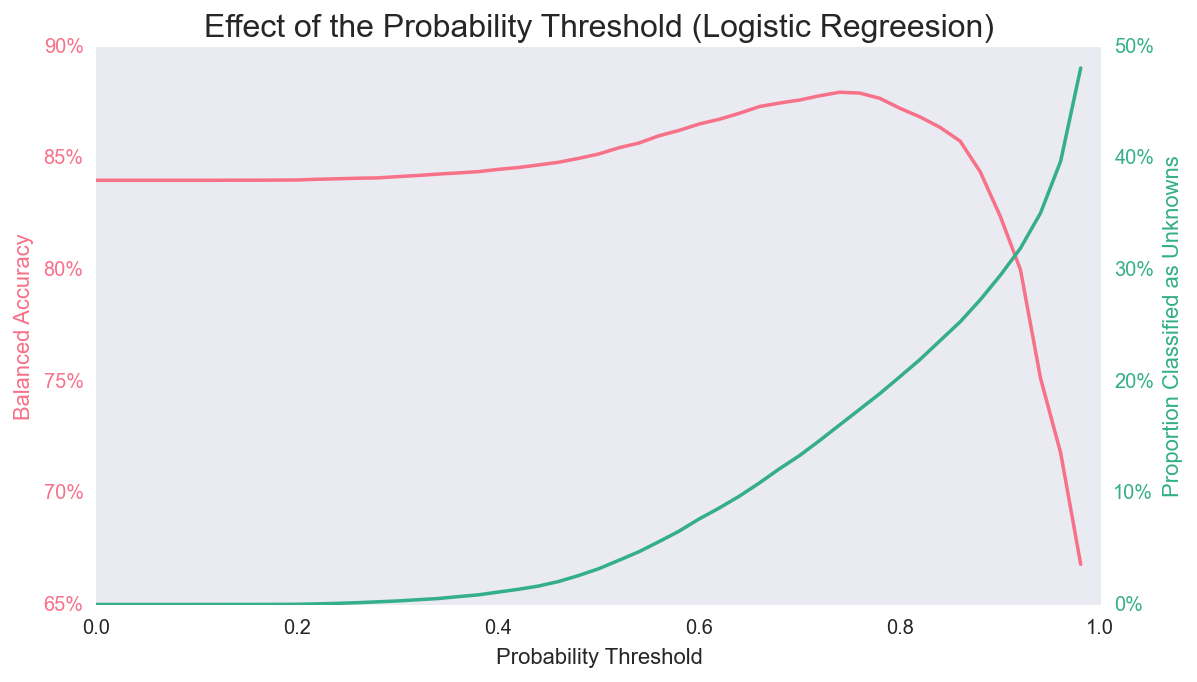

In [5]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

ax1.plot(thresholds_logistic, accuracies_logistic, color=colour1)
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Effect of the Probability Threshold (Logistic Regreesion)')
format_as_percent = lambda x, pos: "{:.0f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)

ax2 = ax1.twinx()
ax2.plot(thresholds_logistic, percent_unknowns_logistic, color=colour2)
ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()

It's very strange how the accuracy actually goes down as we increase the probability threshold. Let's investigate this by binning the results into 10 bins.

In [ ]:
sorted_test = DataFrame(np.concatenate((X_test, y_test[np.newaxis].T, max_probs[np.newaxis].T), axis=1)).sort(12)
no_bins = 10
bin_size = int(len(sorted_test) / no_bins)
X_test_bins, y_test_bins, probs_bin, percent_unknowns_logistics, accuracies_logistics  = [], [], [], [], []
thresholds_logistic = np.arange(0, 1, 0.02)

for b in range(no_bins):
    X_test_bins.append(np.array(sorted_test[b * bin_size:b * bin_size + bin_size][[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).astype(float))
    y_test_bins.append(np.array(sorted_test[b * bin_size:b * bin_size + bin_size][[11]]))
    probs_bin.append(np.array(sorted_test[b * bin_size:b * bin_size + bin_size][[12]]).astype(float))
    
    percent_unknowns_logistic = []
    accuracies_logistic = []
    for t in thresholds_logistic:
        # select only objects from test set where the likelihood from all classes is higher than threshold
        high_probabilities_index = probs_bin[b] > t
        high_probabilities_index = high_probabilities_index.T[0]
        percent_unknowns_logistic.append(sum(np.invert(high_probabilities_index)) / bin_size)
        X_test_high = X_test_bins[b][high_probabilities_index]
        y_test_high = y_test_bins[b][high_probabilities_index]

        # with above selection, predict the class
        y_pred_test_high = clf_logistic.predict(X_test_high)
        confusion_test_high = metrics.confusion_matrix(y_test_high, y_pred_test_high)
        accuracies_logistic.append(balanced_accuracy_expected(confusion_test_high))
        
    percent_unknowns_logistics.append(percent_unknowns_logistic)
    accuracies_logistics.append(accuracies_logistic)

In [ ]:
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
colour1 = sns.color_palette()[0]
colour2 = sns.color_palette()[3]

for a, p in zip(accuracies_logistics, percent_unknowns_logistics):
    ax1.plot(thresholds_logistic, a, color=colour1)
    ax2.plot(thresholds_logistic, p, color=colour2)
    
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Effect of the Probability Threshold (Logistic Regreesion)')
format_as_percent = lambda x, pos: "{:.0f}%".format(x * 100)
ax1.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax1.set_ylabel('Balanced Accuracy', color=colour1)
for tl in ax1.get_yticklabels():
    tl.set_color(colour1)



ax2.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent))
ax2.set_ylabel('Proportion Classified as Unknowns', color=colour2)
for tl in ax2.get_yticklabels():
    tl.set_color(colour2)

plt.show()